# Panaroma stitching

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
import imutils

In [2]:
feature_extractor = "sift"

## Image Loading

In [3]:
image1 = cv2.imread("secondPic1.jpg")
image1_gray = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
image2 = cv2.imread("secondPic2.jpg")
image2_gray = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

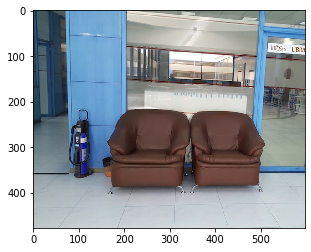

In [4]:
plt.imshow(image1)

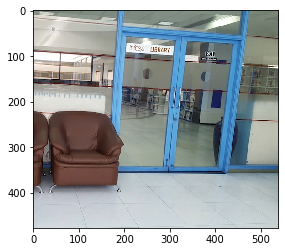

In [5]:
plt.imshow(image2)

## Detect Keypoints

In [6]:
def findDescriptors(image, method):
    if method == "sift":
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == "surf":
        descriptor = cv2.xfeatures2d.SURF_create()
    
    (keypoints, features) = descriptor.detectAndCompute(image,None)
    return (keypoints, features)

In [7]:
keypointsA, featuresA = findDescriptors(image1_gray, method=feature_extractor)
keypointsB, featuresB = findDescriptors(image2_gray, method=feature_extractor)

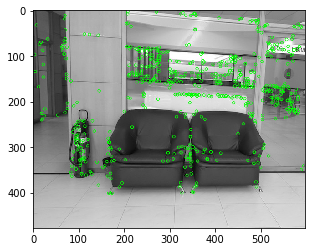

In [8]:
plt.imshow(cv2.drawKeypoints(image1_gray,keypointsA,None,color=(0,255,0)))

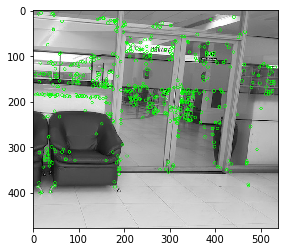

In [9]:
plt.imshow(cv2.drawKeypoints(image2_gray,keypointsB,None,color=(0,255,0)))

## Feature Matching

In [10]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [11]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Raw matches (knn): 673


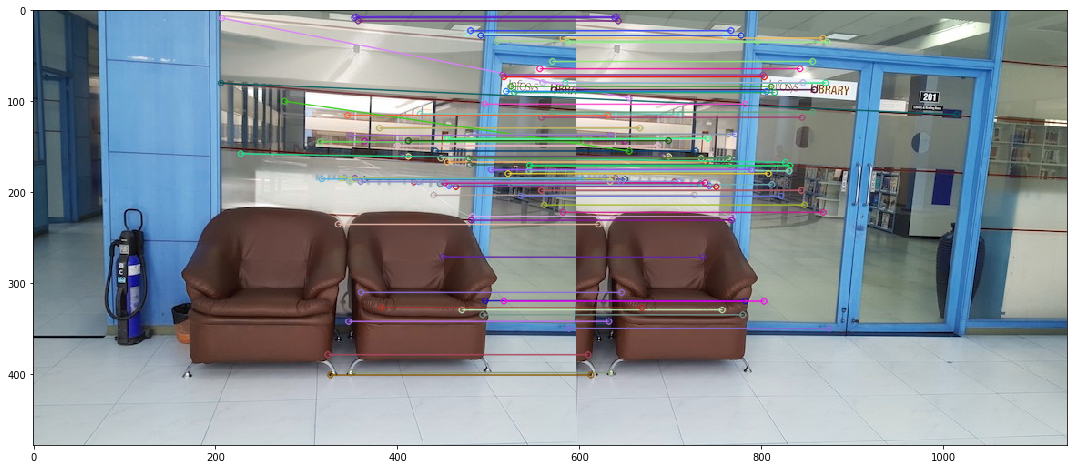

In [12]:
fig = plt.figure(figsize=(20,8))

matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
img3 = cv2.drawMatches(image1,keypointsA,image2,keypointsB,np.random.choice(matches,100),
                        None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

## Find homography

In [13]:
def getHomography(keypointsA, keypointsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    keypointsA = np.float32([kp.pt for kp in keypointsA])
    keypointsB = np.float32([kp.pt for kp in keypointsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([keypointsA[m.queryIdx] for m in matches])
        ptsB = np.float32([keypointsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [14]:
M = getHomography(keypointsA, keypointsB, featuresA, featuresB, matches, reprojThresh=4)
(matches, H, status) = M

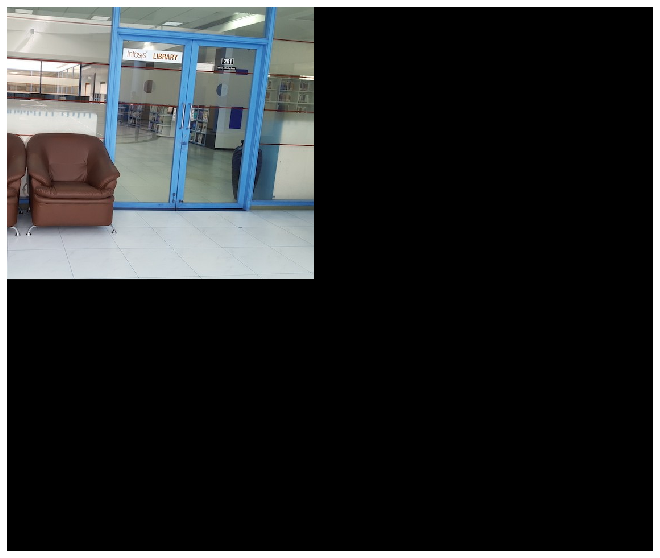

In [15]:
# Apply panorama correction
width = image1.shape[1] + image2.shape[1]
height = image1.shape[0] + image2.shape[0]

result = cv2.warpPerspective(image1, H, (width, height))
result[0:image2.shape[0], 0:image2.shape[1]] = image2

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

## Stitch images

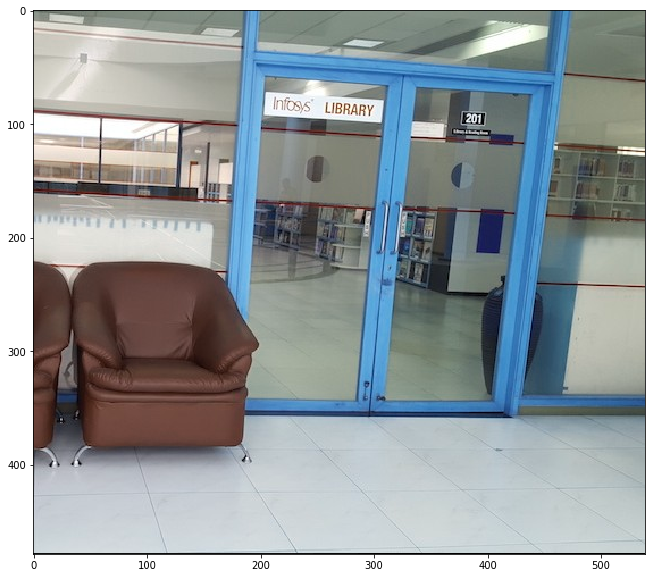

In [16]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)